# Прогнозирование вероятности оттока пользователей для фитнес-центров

**Цель проекта** - провести анализ и подготовить план действий по удержанию клиентов.
А именно:
- Научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- Сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- Проанализировать основные признаки, наиболее сильно влияющие на отток;
- Сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
  1. Выделить целевые группы клиентов;
  2. Предложить меры по снижению оттока;
  3. Определить другие особенности взаимодействия с клиентами. 

*В качестве входных данных используется датасет содержащий данные на месяц до оттока и факт оттока на определённый месяц.*

**Ход анализа:**
1. Обзор данных;
2. Предобработка данных;
3. Проведение исследовательского анализа данных (EDA);
4. Построение модели прогнозирования оттока клиентов;
5. Кластеризация клиентов

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score

from scipy.cluster.hierarchy import dendrogram, linkage

In [3]:
%config InlineBackend.figure_format = 'retina'

In [4]:
df = pd.read_csv('gym_churn.csv')

## Обзор данных

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

**Согласно документации к данным:**

- Данные клиента за предыдущий до проверки факта оттока месяц:
    - `gender` — пол;  
    - `Near_Location` — проживание или работа в районе, где находится фитнес-центр;  
    - `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);  
    - `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);  
    - `Phone` — наличие контактного телефона;  
    - `Age` — возраст;  
    - `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах);  
- Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
    - `Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);  
    - `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);  
    - `Group_visits` — факт посещения групповых занятий;  
    - `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;  
    - `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;  
    - `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон;  
    - `Churn` — факт оттока в текущем месяце.

In [6]:
df.sample(5)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
340,1,1,0,0,0,6,1,29,116.345125,6.0,4,1.947273,1.843212,0
1145,0,1,0,0,1,1,1,27,229.321912,1.0,4,1.763502,1.848363,0
3063,1,0,1,1,1,6,0,29,174.383860,6.0,11,3.448108,3.392125,0
868,1,1,0,0,0,1,0,28,104.550018,1.0,6,2.073813,2.155438,0
230,0,1,0,0,1,6,0,33,27.911908,6.0,1,2.016016,2.157848,0


In [7]:
df.duplicated().sum()

0

### Вывод

- В датасете нет пропусков;
- В датасете нет дубликатов;
- Названия столбцов содержат разный регистр.

## Предобработка данных

*Чтобы предобработать данные, приведем названия столбцов к нижнему регистру.*

In [8]:
df.columns = df.columns.str.lower()

In [9]:
df.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

## Исследовательского анализа данных (EDA)

**Чтобы провести исследовательский анализ данных, выполним следующие действия:**
- Проверим описательную статистику;
- Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался;
- Построим гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток);
- Построим матрицу корреляций.

### Описательная статистика

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


- В датасете поровну мужчин и женщин;
- Клиенты в основном проживают или работают рядом с фитнес-центром;
- Половина клиентов сотрудники компании-партнёра фитнес-центра;
- 30% клиентов пришло в рамках акции «приведи друга»;
- Средний возраст клиентов 29 лет, минимальный 18, максимальный 41;
- В среднем больше всего пользуется популярностью абонемент на 6 месяцев;
- 40% клиентов посещают групповые занятия;
- В среднем частота посещений в неделю за все время и за предыдущий месяц практически одинаковые;
- Отток 26%.

### Средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался

In [11]:
features_of_clients = df.groupby('churn').mean().T

In [12]:
features_of_clients

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


### Гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)

In [13]:
def plot_hist(data, feature, dimension):
    """
    Функция для построения гистрограмм по заданным признакам.
    
    data - датафрейм
    feature - список названий признаков
    dimension - разделитель
    """
    
    fig = plt.figure(figsize=(16, 12), constrained_layout=True)
    counter = 1
    for i in range(1, 5):
        for j in range(1, 5):
            ax = plt.subplot(4, 4, counter)
            sns.histplot(data[[feature[counter-1], dimension]], 
                         x=data[feature[counter-1]], 
                         hue=dimension, 
                         ax=ax, 
                         palette="pastel", 
                         multiple="fill"
                        )
            sns.move_legend(ax, 
                            "lower center", 
                            bbox_to_anchor=(.5, 1), 
                            ncol=data[dimension].nunique(), 
                            frameon=False
                            )
            if counter < len(feature):
                counter += 1
            else: 
                break


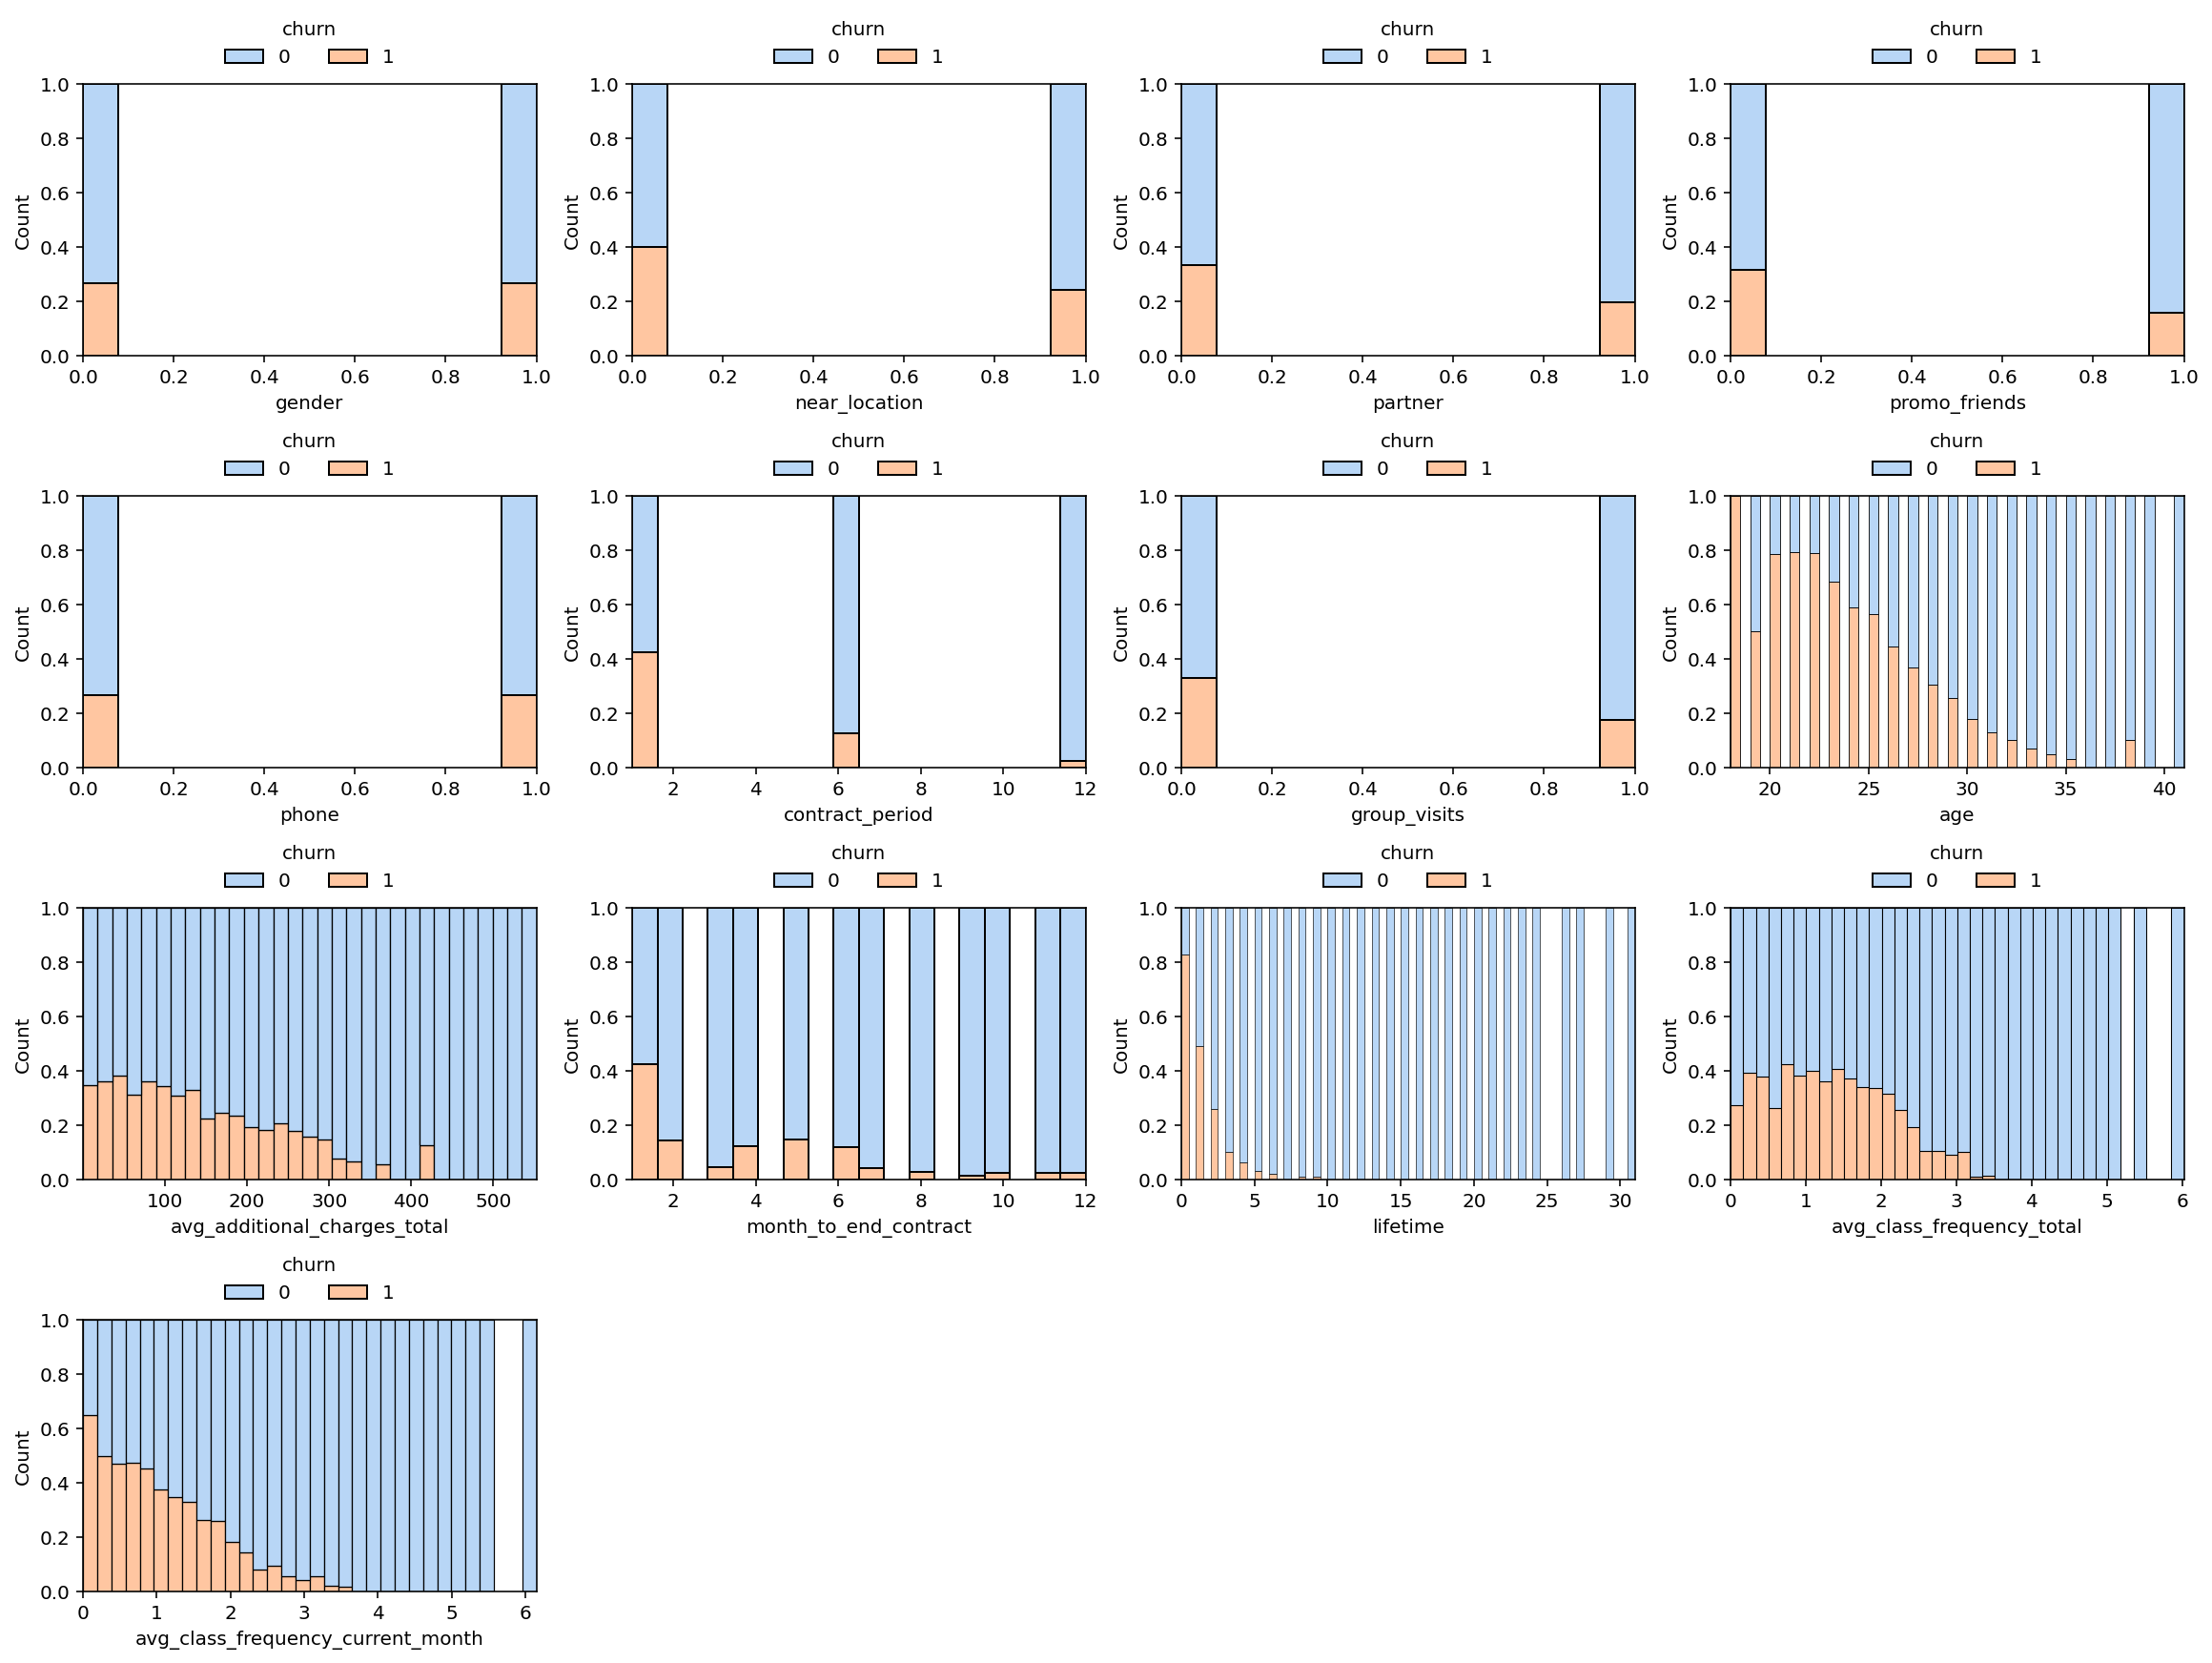

In [14]:
plot_hist(df, df.drop('churn', axis=1).columns, 'churn')

### Матрица корреляций

In [15]:
df.corr()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
gender,1.000000,0.006699,-0.010463,-0.005033,-0.008542,0.000502,0.017879,0.013807,-0.009334,-0.001281,0.013579,0.014620,0.009156,0.000708
near_location,0.006699,1.000000,-0.005119,0.210964,-0.015763,0.150233,0.154728,0.058358,0.040761,0.143961,0.070921,0.043127,0.062664,-0.128098
partner,-0.010463,-0.005119,1.000000,0.451960,0.009970,0.306166,0.022710,0.047480,0.022941,0.294632,0.061229,0.024938,0.045561,-0.157986
promo_friends,-0.005033,0.210964,0.451960,1.000000,0.001982,0.244552,0.120170,0.050113,0.036898,0.239553,0.072721,0.028063,0.053768,-0.162233
phone,-0.008542,-0.015763,0.009970,0.001982,1.000000,-0.006893,-0.010099,-0.011403,0.009279,-0.011196,-0.018801,0.008340,0.013375,-0.001177
contract_period,0.000502,0.150233,0.306166,0.244552,-0.006893,1.000000,0.169991,0.138249,0.111445,0.973064,0.170725,0.096211,0.159407,-0.389984
group_visits,0.017879,0.154728,0.022710,0.120170,-0.010099,0.169991,1.000000,0.080934,0.032079,0.163703,0.075853,0.056695,0.075923,-0.175325
age,0.013807,0.058358,0.047480,0.050113,-0.011403,0.138249,0.080934,1.000000,0.080240,0.134511,0.164693,0.119953,0.183095,-0.404735
avg_additional_charges_total,-0.009334,0.040761,0.022941,0.036898,0.009279,0.111445,0.032079,0.080240,1.000000,0.113958,0.079028,0.044426,0.079570,-0.198697
month_to_end_contract,-0.001281,0.143961,0.294632,0.239553,-0.011196,0.973064,0.163703,0.134511,0.113958,1.000000,0.161078,0.085387,0.147605,-0.381393


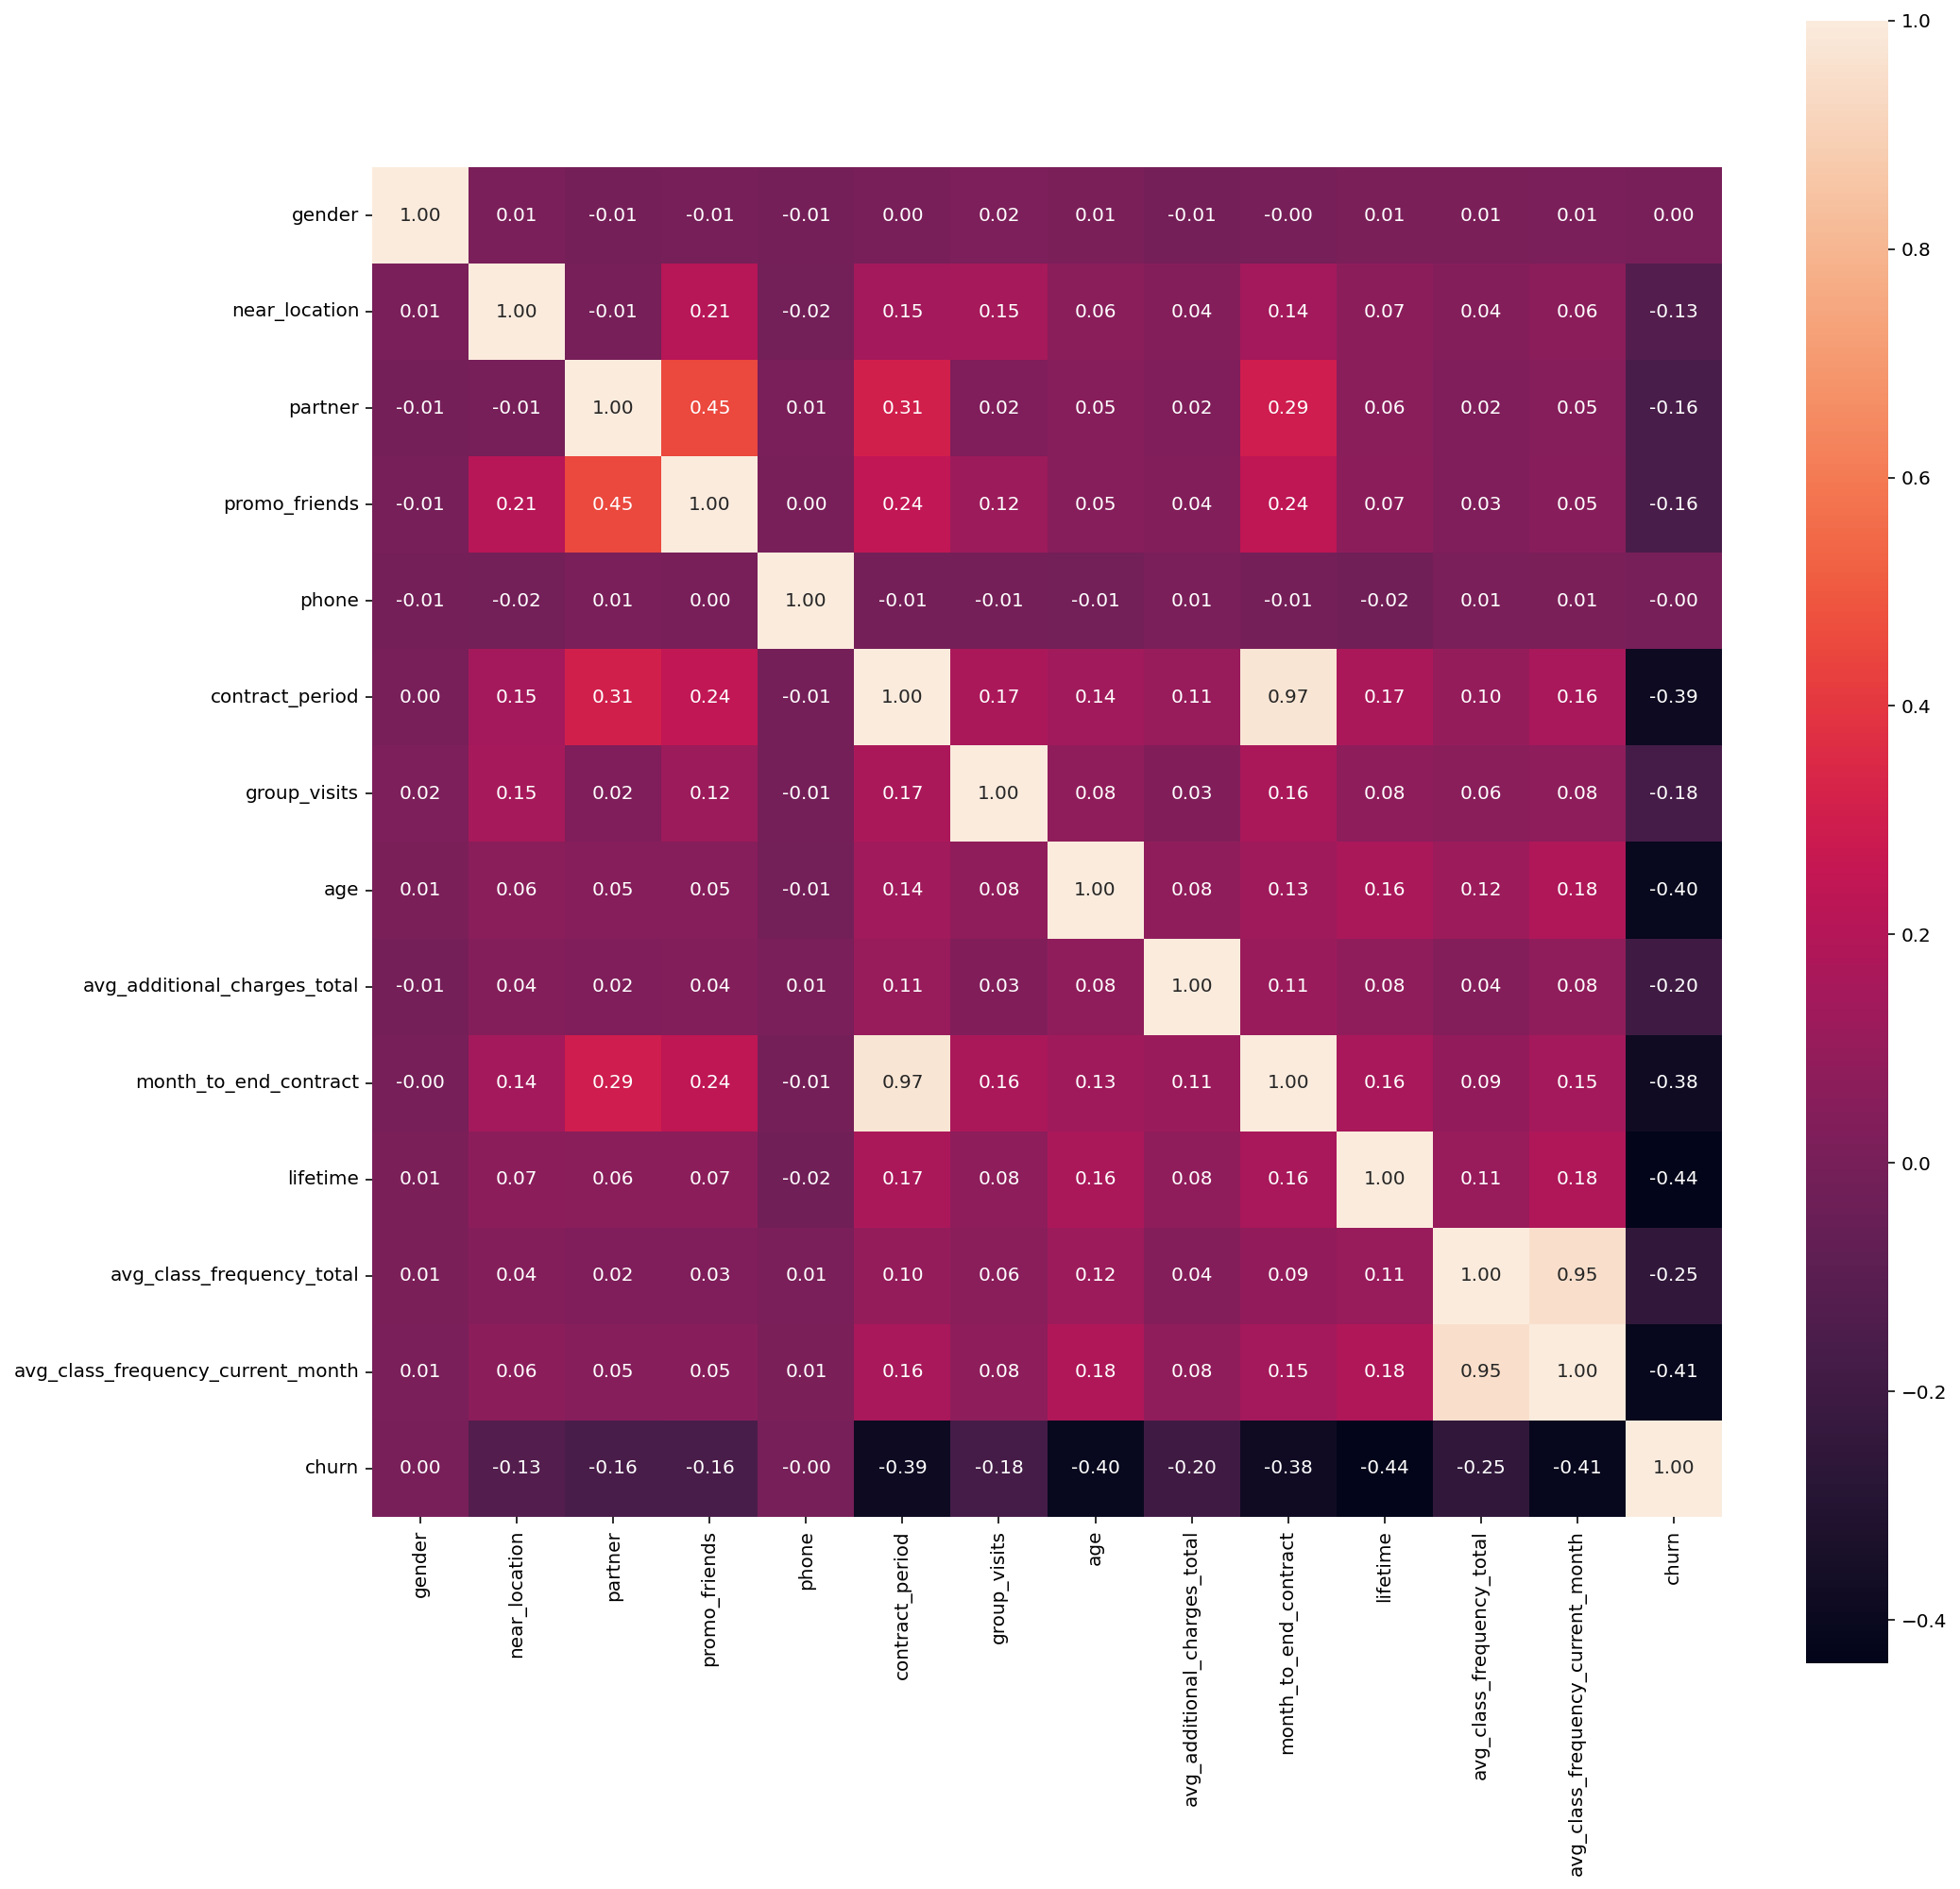

In [16]:
plt.figure(figsize = (16,16))
sns.heatmap(df.corr(), annot=True, square=True, fmt='.2f');

**Имеются сильно скоррелированные признаки:**
- Длительность текущего действующего абонемента(contract_period) и срок до окончания текущего действующего абонемента(month_to_end_contract);
- Суммарная выручка от других услуг фитнес-центра(avg_additional_charges_total) и средняя частота посещений в неделю за предыдущий месяц(avg_class_frequency_current_month).

### Вывод

- Из тех клиентов что остались больше сотрудников компаний-партнеров;
- В два раза больше остаются те, кого привели друзья;
- Чем больше возраст, тем вероятнее, что клиент останется;
- Кто решил остаться покупает абонемент на более длительный промежуток времени;
- Те кто ушел, меньше ходили на групповые занятия;
- И меньше тратились на сопутствующие услуги;
- В среднем клиенты уходили в первый месяц;
- И посещений в неделю у тех кто ушел в среднем всего одно.

**Из этого всего следует, что те кто решил остаться, скорее всего имеют скидки как сотрудники компании-партнера, плюс акция "приведи друга" оказывает положительное влияние на клиента, заниматься с друзьями интереснее. Так же, те кто решил остаться подходят более сознательно к фитнесу, покупают абонемент на длительный срок и посещают групповые занятия, и ходят в среднем два раза в неделю.**

**Имеются сильно скоррелированные признаки:**
- Длительность текущего действующего абонемента(contract_period) и срок до окончания текущего действующего абонемента(month_to_end_contract);
- Суммарная выручка от других услуг фитнес-центра(avg_additional_charges_total) и средняя частота посещений в неделю за предыдущий месяц(avg_class_frequency_current_month).

## Построение модели прогнозирования оттока клиентов

**Будем строить модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце. В качестве алгоритмов выберем логистическую регрессию и случайный лес.**

In [17]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = df.drop('churn', axis=1)
y = df['churn'] 

In [18]:
# разделим модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [19]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.fit_transform(X_test)

*Алгоритм случайного леса устойчив к мультиколлинеарности, так же как и логистическая регрессия из-за встроенной регуляризации, поэтому удалять сильно скоррелированные признаки не будем.*

In [20]:
# зададим алгоритм для нашей модели логистической регрессии
lr_model = LogisticRegression(solver='liblinear', random_state=0)

In [21]:
# зададим алгоритм для нашей модели случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state=0)

In [22]:
# обучим модель логистической регрессии
lr_model.fit(X_train_sc, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [23]:
# обучим модель случайного леса
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [24]:
# сделаем прогноз
lr_predictions = lr_model.predict(X_test_sc) 

In [25]:
# сделаем прогноз
rf_predictions = rf_model.predict(X_test)

**Сравним метрики для этих моделей.**

In [26]:
def print_all_metrics(y_true, y_pred, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))

In [27]:
print_all_metrics(
    y_test,
    lr_predictions,
    title='Метрики для модели логистической регрессии:',
)

Метрики для модели логистической регрессии:
	Accuracy: 0.93
	Precision: 0.89
	Recall: 0.85


In [28]:
print_all_metrics(
    y_test, 
    rf_predictions,
    title='Метрики для модели случайного леса:'
)

Метрики для модели случайного леса:
	Accuracy: 0.92
	Precision: 0.88
	Recall: 0.83


### Вывод

По всем метрикам более простой алгоритм логистической регрессии обходит случайный лес.

## Кластеризация клиентов

**Для этого выполним следующие действия:**

- Стандартизируем данные;
- Построим матрицу расстояний;
- Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов;
- Построим распределения признаков для кластеров;
- Для каждого полученного кластера посчитаем долю оттока.

### Стандартизация данных

In [29]:
sc = StandardScaler()
X_sc = sc.fit_transform(df.drop('churn', axis=1))
linked = linkage(X_sc, method = 'ward') 

### Построение матрицы расстояний

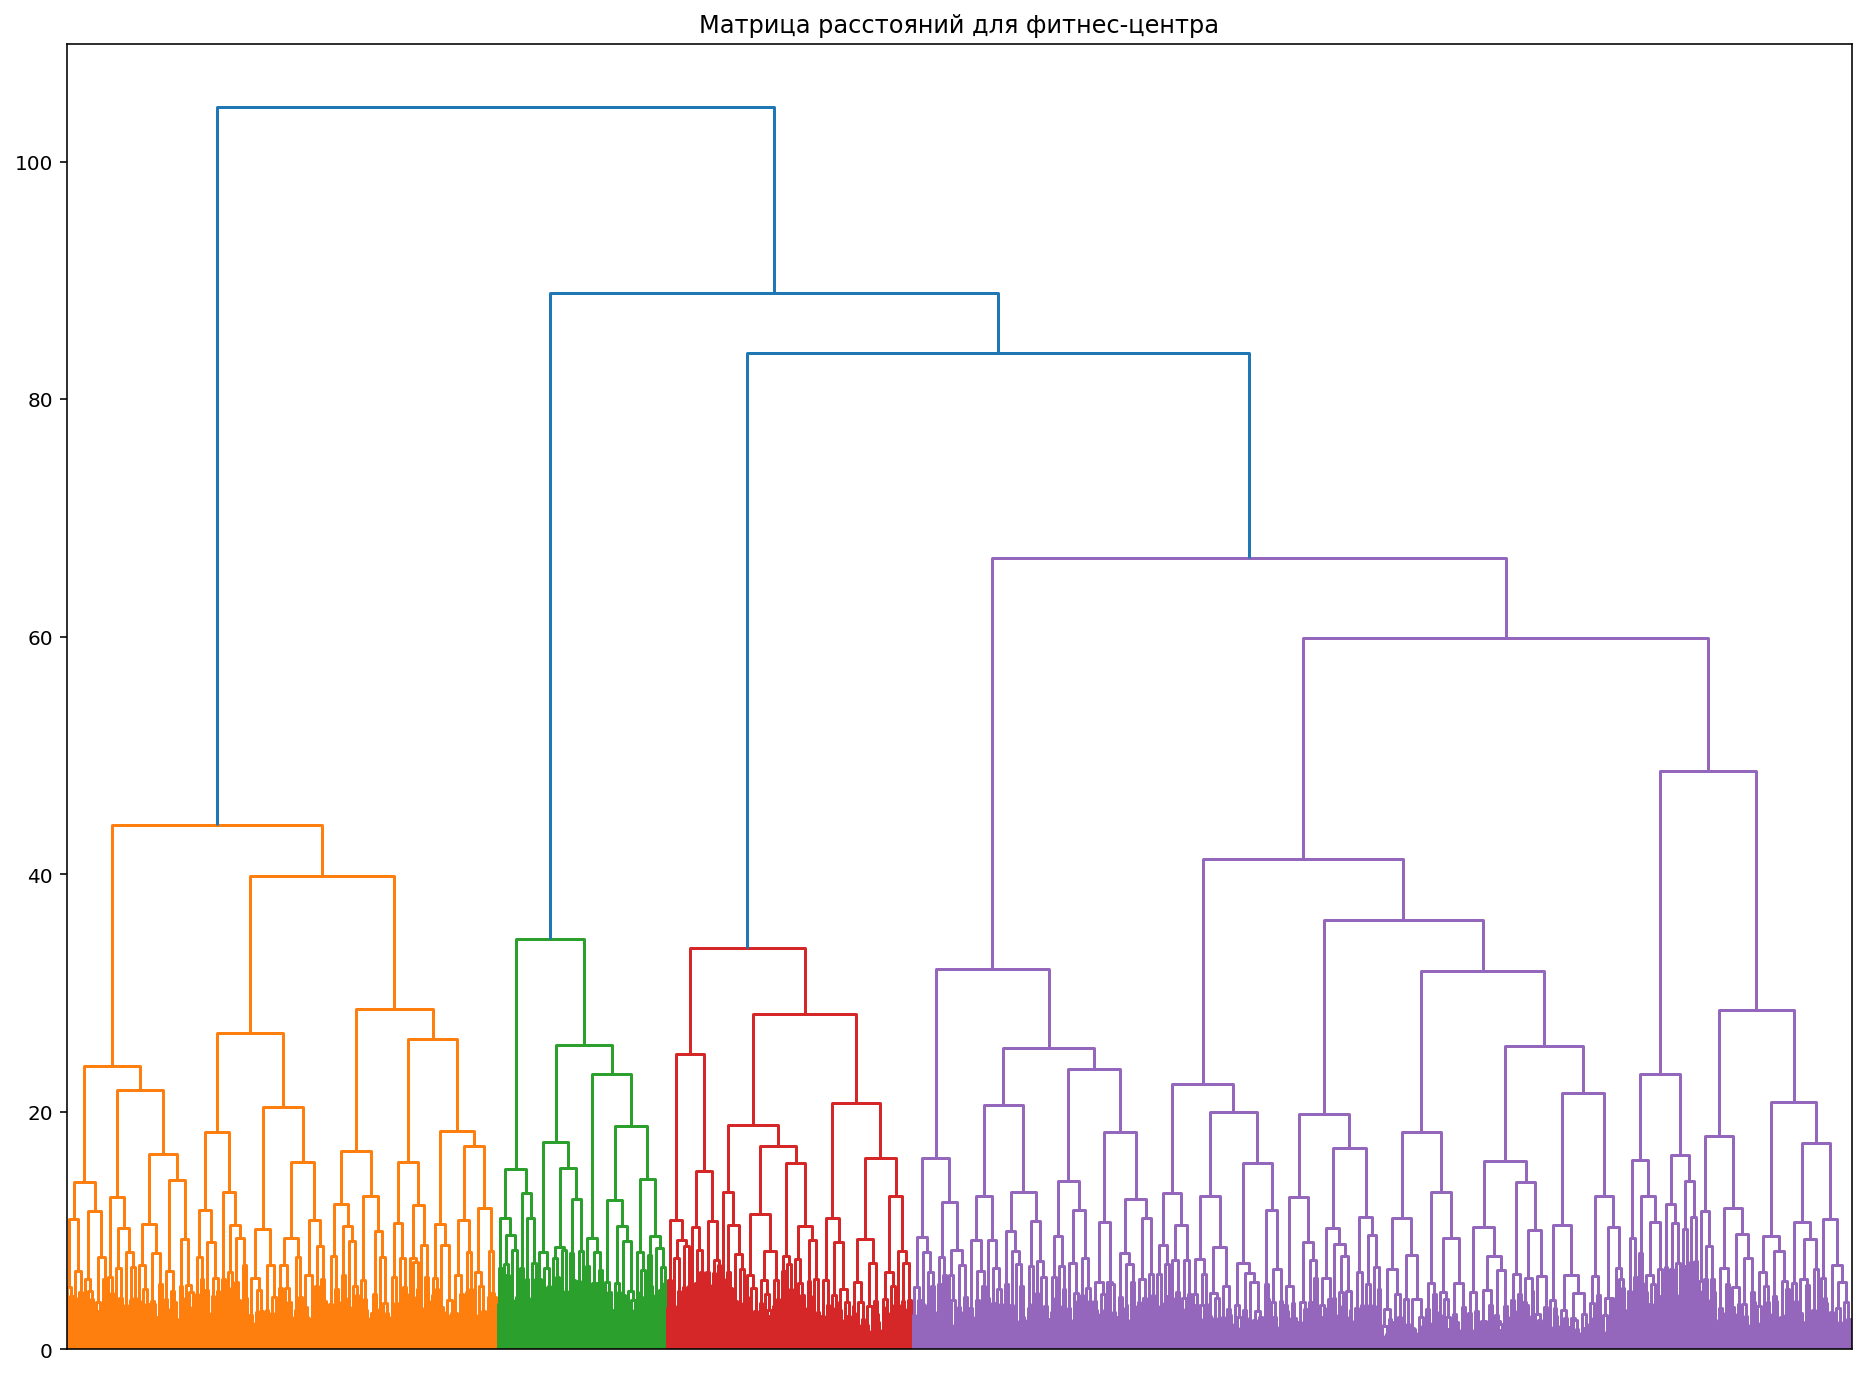

In [30]:
plt.figure(figsize=(16, 12))  
dendrogram(linked, orientation='top', no_labels=True)
plt.title('Матрица расстояний для фитнес-центра')
plt.show() 

**Судя по графику оптимальным числом кластеров является 5.**

### Обучение модели кластеризации на основании алгоритма K-Means

In [31]:
# задаём число кластеров, равное 5
km = KMeans(n_clusters=5, random_state=0) 

In [32]:
# применяем алгоритм к данным и формируем вектор кластеров 
labels = km.fit_predict(X_sc) 

In [33]:
df['cluster'] = labels

In [34]:
df.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn,cluster
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0,1
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0,3
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0,3


In [44]:
feature_by_cluster = df.groupby('cluster').agg('mean').T
feature_by_cluster['mean'] = df.drop('cluster', axis=1).mean()

In [90]:
feature_by_cluster
feature_by_cluster.style.background_gradient(axis=1, cmap="YlGn")

cluster,0,1,2,3,4,mean
gender,0.502970,0.522078,0.495050,0.485737,0.559666,0.510250
near_location,0.959406,0.862338,0.000000,1.000000,0.976134,0.845250
partner,0.783168,0.470130,0.463366,0.350238,0.356802,0.486750
promo_friends,0.574257,0.306494,0.079208,0.240095,0.230310,0.308500
phone,1.000000,0.000000,1.000000,1.000000,0.998807,0.903500
contract_period,10.889109,4.787013,2.352475,1.948494,2.669451,4.681250
group_visits,0.542574,0.425974,0.215842,0.341521,0.473747,0.412250
age,29.982178,29.301299,28.477228,28.167987,30.125298,29.184250
avg_additional_charges_total,160.761016,143.957664,135.457501,131.622204,161.657905,146.943728
month_to_end_contract,9.954455,4.475325,2.198020,1.856577,2.459427,4.322750


**По данной таблице можно заметить, что:**

- Клиенты, которые проживают или работают рядом с фитнес-центром, и являющиеся партнерами, практически не уходят, покупают долгий абонемент и тратят много на сопутствующие услуги;
- Клиенты, которые занимаются раз в неделю, тратят на сопутствующие услуги меньше среднего, мало ходят на групповые занятия и покупают короткие абонементы, больше подвержены оттоку. 

### Распределение признаков для кластеров

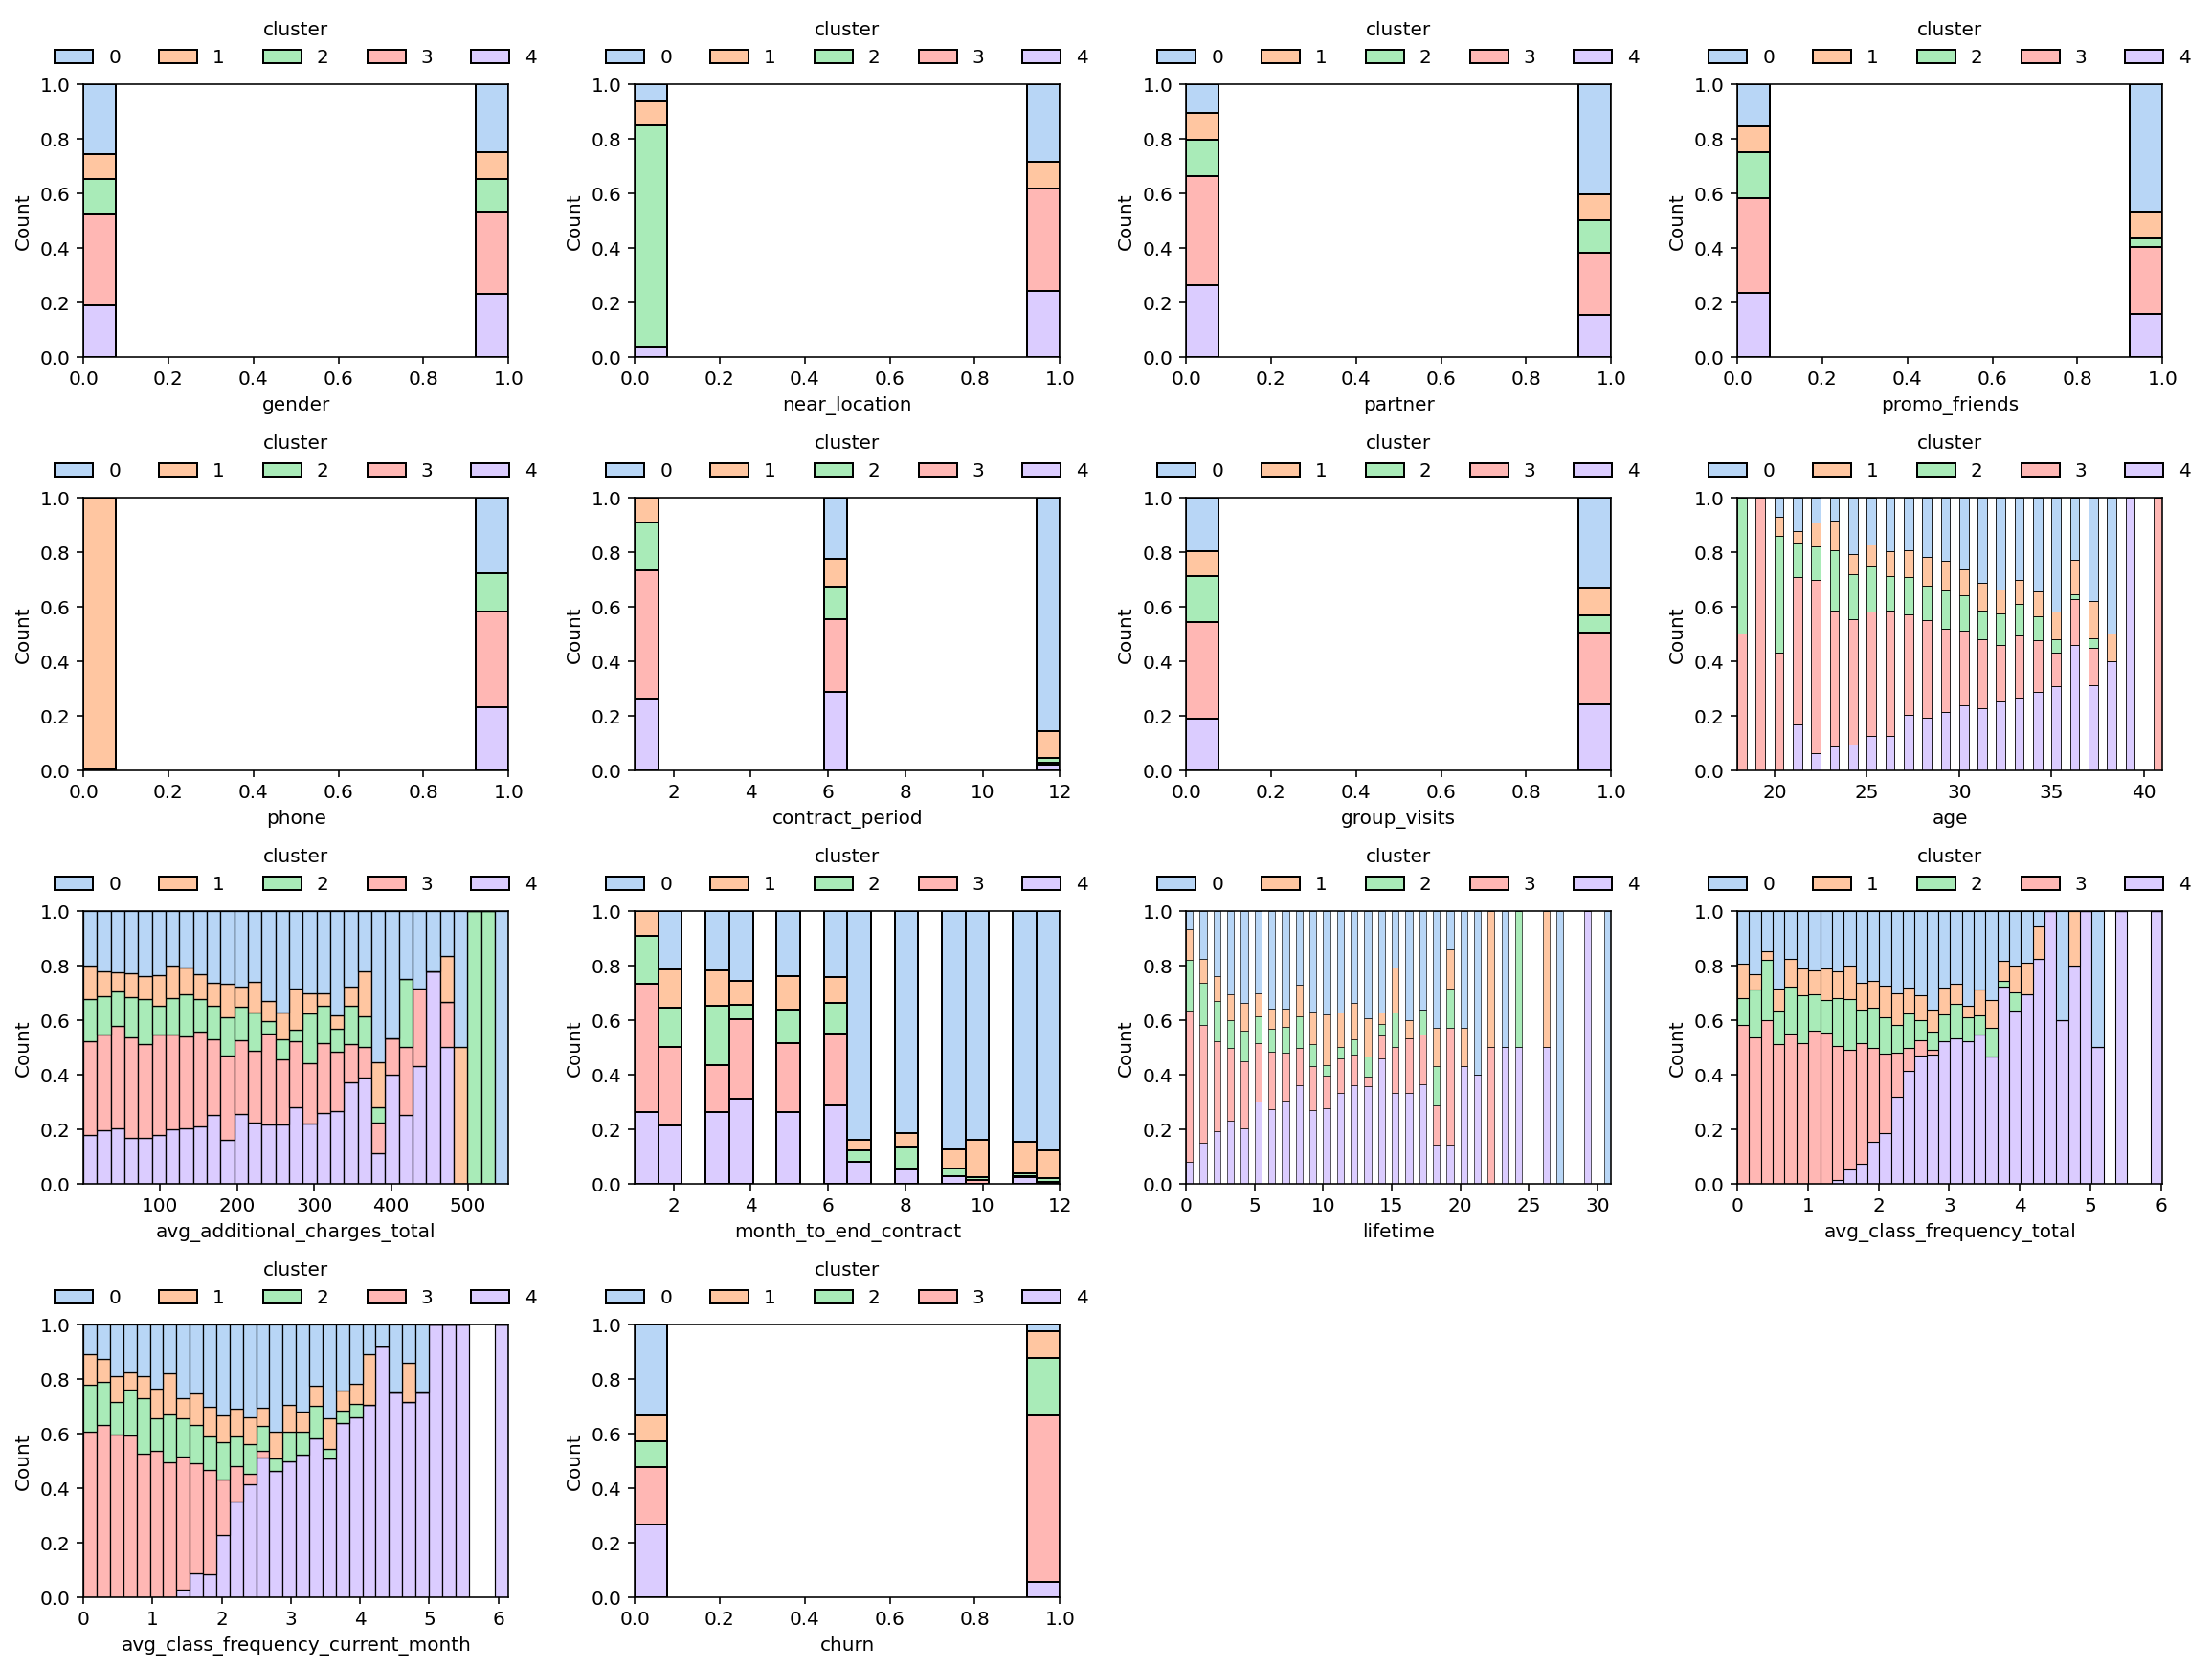

In [36]:
plot_hist(df, df.drop(['cluster'], axis=1).columns, 'cluster')

### Доля оттока для каждого кластера

In [37]:
df.groupby('cluster').agg({'gender': 'count', 'churn': 'mean'}).rename(columns={'gender': 'clients'})

,clients,churn
cluster,,
0,1010,0.027723
1,385,0.267532
2,505,0.443564
3,1262,0.514263
4,838,0.068019


### Вывод

- Самыми надежными являются 0 и 4 кластеры; 
- Больше всего оттока в кластерах 2 и 3;
- Пол клиента не влияет на отток;
- Наличие друзей влияет на кластер 0;
- Клиенты из кластера 1 не оставляют свои номера телефонов и берут самые короткие абонементы, они же меньше всего преобретают дополнительные услуги;
- Клиенты из 0 и 4 кластера более возростные и они же больше всего посещают фитнес-центр в неделю;
- Все клиенты из кластера 2 проживают или работают не рядом с фитнес-центром.

## Общий вывод

**За время выполнения проекта была построена модель прогнозирующая отток клиентов, в качестве алгоритма был выбран алгоритм логистической регрессии, он показал долю правильных ответов в 93%, точность в 89% и полноту в 85%.**

**По исследовательскому анализу данных:**
- Из тех клиентов что остались больше сотрудников компаний-партнеров;
- В два раза больше остаются те, кого привели друзья;
- Чем больше возраст, тем вероятнее, что клиент останется;
- Кто решил остаться покупает абонемент на более длительный промежуток времени;
- Те кто ушел, меньше ходили на групповые занятия;
- И меньше тратились на сопутствующие услуги;
- В среднем клиенты уходили в первый месяц;
- И посещений в неделю у тех кто ушел в среднем всего одно.

**Алгоритмом K-Means клиенты были разделены на 5 кластеров(групп):** 
- Самыми лояльными и приносящими прибыль являются клиенты более возростной группы, которые проживают или работают рядом с фитнес-центром, являющиеся партнерами, и пришедшими по рекомендации друзей, они попали в кластер 0 и 4;
- Подвержены оттоку клиенты, которые занимаются раз в неделю, тратят на сопутствующие услуги меньше среднего, мало ходят на групповые занятия, покупают короткие абонементы и проживают не рядом с фитнес-центром, они попали в кластер 2 и 3;
- Кластер 1 занимает промежуточное положение, из особенностей, никто среди клиентов попавших в него не оставил контакты для связи.

**Рекомендации для стратегии взаимодействия с клиентами и их удержания:**
- Расширить охват компаний-партнеров находящихся рядом с фитнес-центрами;
- Продолжить акцию «приведи друга»;
- Чтобы удержать клиентов из неблизлежащих районов предложить скидку на абонемент при переходе из других сетей фитнес-центров;
- Проводить больше бесплатных вводных уроков по групповым занятиям.